# CMSE 201 Final Project - Model 

### &#9989; Minh Anh Dang
### &#9989; Section_005

# ___COVID-19 Epidemiology Models___

## Background and Motivation

COVID-19 is an infectious disease caused by the SARS-CoV-2 virus. The virus can spread from an infected person’s mouth or nose in small liquid particles when they cough, sneeze, speak, sing or breathe [1]. As such, one of the simplest and earliest measures one can take to decrease the risk of being infected is wearing a face mask and social distancing. However, since SARS-CoV-2 virus is a new strain, most of humanity is susceptible to COVID-19. To slow down to spread of the virus in the long term, vaccines are needed.

In this project, I want to investigate the following question: How effective are social distancing and vaccines at slowing down the spread of COVID-19? To answer my question, I will use compartmental epidemiology models, in particular, two modified SEAIR models (Susceptible, Exposed (Latent Period), Asymptomatic but still infectious, Symptomatic and Infectious, and Recovered).

## Methodology

I plan to create 2 models:

1. The Interaction model (SEAIRP a.k.a SEAIR - Pathogens) takes into account both the interactions between human - infectious environments and between human - infectious humans. I will then manipulate the proportions of both interactions to see the differences in the population between high and low interactions.

2. The Vaccinated model (SEAIRV a.k.a SEAIR - Vaccinated) and then manipulate the vaccination rate to see the differences in the population that has no vaccination and some percentage of vaccination.

These two models will not take into account:

1. Any changes to the human population other than the natural birth and death rate, and death rate due to COVID-19

2. The rate of being hospitalized

3. The exit rate from asymptomatic to symptomatic

4. Whether some parts of the population are more susceptible to the virus than others.

Because these models are taken from different papers, there are differences in the way some compartments are calculated. As such, these two models will not be compared to each other.

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This model is taken from the paper below [2]. This model takes into account both the interactions 
# between human - infectious environments and between human - infectious humans.

def SEAIRP(time, curr_vals, parameters):
    parameters = [b, mu, muP, beta1, beta2 , psi, delta, omega, 
                  sigma, gammaA, gammaI, alpha1, alpha2, nuA, nuI]
    S, E, A, I, R, P = curr_vals
    
    # The model equations (see Mwalili et al. 2020 [2])
    prate = (beta1 * S * P) / (1 + alpha1 * P)
    hrate = (beta2 * S * (A + I)) / (1 + alpha2 * (A + I))
    
    dSdt = b - prate - hrate + psi * E - mu * S                     # Susceptible
    dEdt = prate + hrate - (psi + mu + omega) * E                   # Exposed
    dAdt = (1 - delta) * omega * E - (mu + sigma) * A - gammaA * A  # Asymptomatic Infectious
    dIdt = delta * omega * E - (mu + sigma) * I - gammaI * I        # Symptomatic Infectious
    dRdt = gammaI * I + gammaA * A - mu * R                         # Recovered
    dPdt = nuA * A + nuI * I - muP * P                              # Pathogen
    
    return [dSdt, dEdt, dAdt, dIdt, dRdt, dPdt]

Text(0, 0.5, 'Population Percentage (%)')

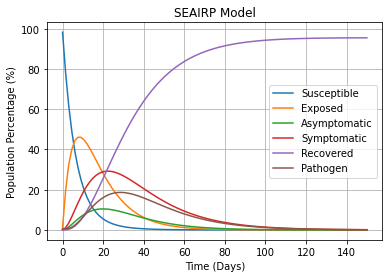

In [3]:
b = 0.00018          # Birth rate of the human population
mu = 1 / (59 * 365)  # Natural human death rate
sigma = 0.0018       # Death rate due to the coronavirus
psi = 0.0051         # Progression rate from E back to S due to robust immune system
omega = 0.09         # Progression rate from E to either A or I
delta = 0.7          # Proportion of symptomatic infectious people
gammaA = 0.0714      # Rate of recovery of the asymptomatic human population
gammaI = 0.05        # Rate of recovery of the symptomatic population

beta1 = 0.00414      # Rate of transmission from S to E due to contact with P
beta2 = 0.0115       # Rate of transmission from S to E due to contact with A and/or I
alpha1 = 0.1         # Proportion of interaction with an infectious environment
alpha2 = 0.1         # Proportion of interaction with an infectious individual
nuA = 0.05           # Rate of virus spread to environment by asymptomatic infectious individuals
nuI = 0.1            # Rate of virus spread to environment by symptomatic infectious individuals
muP = 0.1724         # Natural death rate of pathogens in the environment

labels = ["Susceptible", "Exposed", "Asymptomatic", "Symptomatic", "Recovered", "Pathogen"]
parameters = [b, mu, muP, beta1, beta2, psi, delta, omega, 
              sigma, gammaA, gammaI, alpha1, alpha2, nuA, nuI]

tmax = 150
time = np.linspace(0, tmax, 100)        # time grid

initial = [93000, 1000, 50, 50, 0, 500] # initial condition

# solve the DEs
soln = solve_ivp(SEAIRP, (0, tmax), initial, t_eval = time, args = [parameters])

# plot results
for i in range(len(labels)):
    plt.plot(time, soln.y[i,:] / sum(initial) * 100, label = labels[i])

plt.legend()
plt.grid()
plt.title("SEAIRP Model")
plt.xlabel("Time (Days)")
plt.ylabel("Population Percentage (%)")

In [4]:
# This model is taken and modified from the paper below [3]. I had taken the liberty to exclude 
# compartment H (Hospitalized) to create a simplified model that ignores the rate of being hospitalized, 
# and the exit rate from the asymptomatic class.

def SEAIRV(time, curr_vals, parameters):
    parameters = [b, mu, psi, delta, omega, v, 
                  sigma, gammaA, gammaI, nu]
    S, E, A, I, R, V = curr_vals
    
    # The model equations (see Diagne et al. 2021 [3])
    hrate = 1.12 * (0.3 * A + 1.8 * I)/94600
    vrate = 0.2 * hrate
    
    dSdt = b - (mu + v + hrate) * S + psi * E + nu * R              # Susceptible
    dVdt = v * S - (vrate + mu) * V                                 # Vaccinated
    dEdt = hrate * S - (mu + psi + omega) * E + vrate * V           # Exposed
    dAdt = (1 - delta) * omega * E - (mu + sigma) * A - gammaA * A  # Asymptomatic Infectious
    dIdt = delta * omega * E - (mu + sigma) * I - gammaI * I        # Symptomatic Infectious
    dRdt = gammaI * I + gammaA * A - (mu + nu) * R                  # Recovered

    return [dSdt, dEdt, dAdt, dIdt, dRdt, dVdt]

Text(0, 0.5, 'Population Percentage (%)')

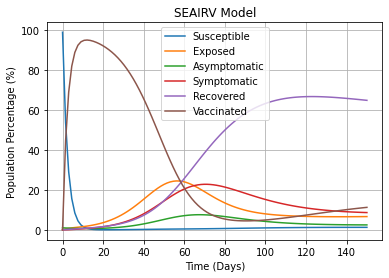

In [5]:
nu = 0.011    # Rate at which individuals lose immunity 
v = 0.4       # Vaccination rate

initial = [93000, 0, 1000, 50, 50, 0] # initial condition
parameters = [b, mu, psi, delta, omega, 
              sigma, gammaA, gammaI, nu]

labels = ["Susceptible", "Exposed", "Asymptomatic", "Symptomatic", "Recovered", "Vaccinated"]

#solve the DEs for population without vaccination
soln = solve_ivp(SEAIRV, (0, tmax), initial, t_eval = time, args = [parameters])

for i in range(len(labels)):
    plt.plot(time, soln.y[i,:] / sum(initial) * 100, label = labels[i])
    
plt.legend()
plt.grid()
plt.title("SEAIRV Model")
plt.xlabel("Time (Days)")
plt.ylabel("Population Percentage (%)")

## Results

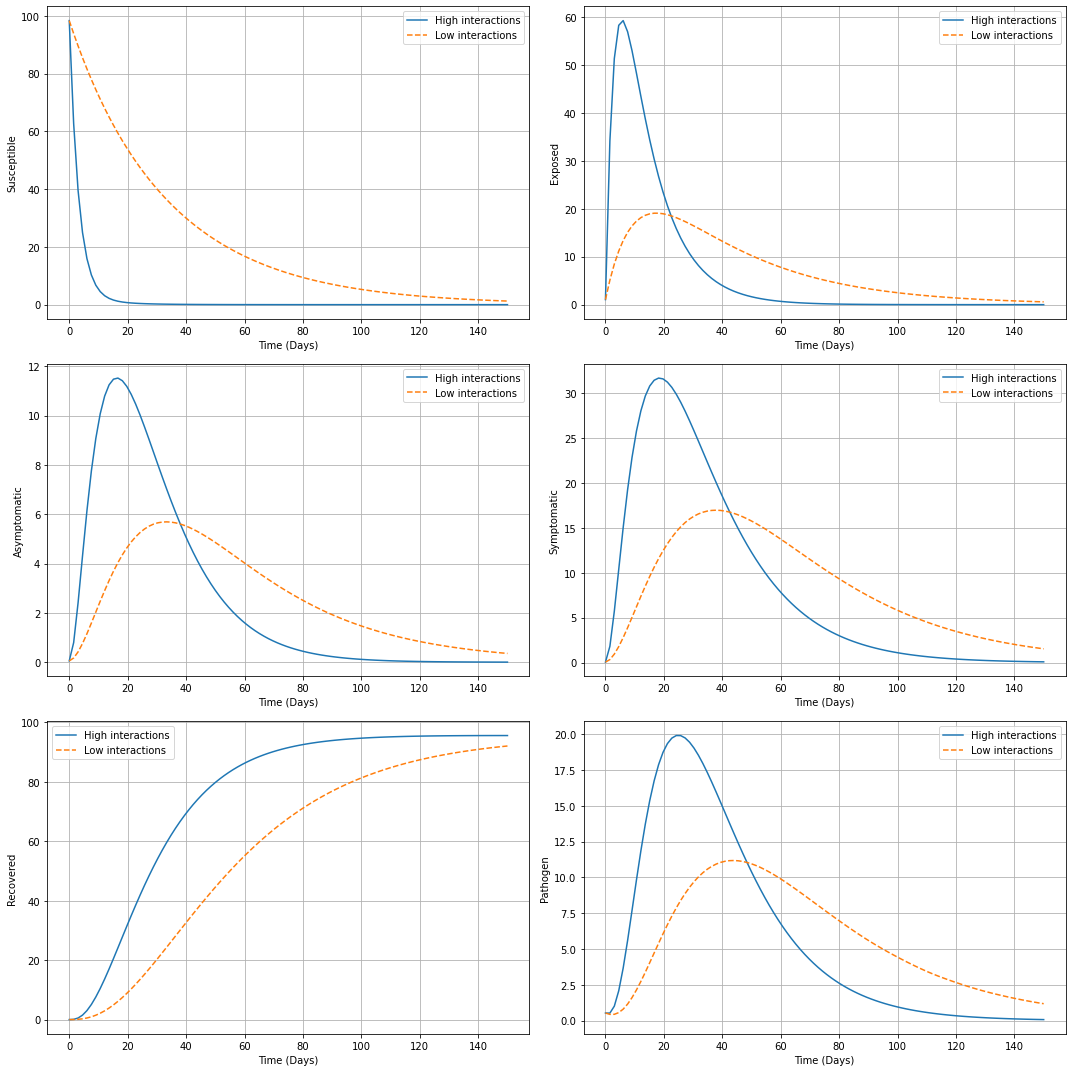

In [6]:
# Population comparison between high and low interactions

initial = [93000, 1000, 50, 50, 0, 500] # initial condition

plt.figure(figsize = (15, 15))
labels = ["Susceptible", "Exposed", "Asymptomatic", "Symptomatic", "Recovered", "Pathogen"]

alpha1 = 0.05 # high risk of getting infected by a contaminated environment
alpha2 = 0.05 # higher chances of getting infected by an individual
parameters = [b, mu, muP, beta1, beta2, psi, delta, omega, 
              sigma, gammaA, gammaI, alpha1, alpha2, nuA, nuI]
soln = solve_ivp(SEAIRP, (0, tmax), initial, t_eval = time, args = [parameters])

# plot each compartment separately
for i in range(len(labels)):
    plt.subplot(3, 2, i + 1)
    plt.plot(time, soln.y[i,:] / sum(initial) * 100, label = "High interactions")
    plt.xlabel("Time (Days)")
    plt.ylabel(labels[i])
    plt.legend()

alpha1 = 0.5 # low risk of getting infected by a contaminated environment
alpha2 = 0.5 # lower chances of getting infected by an individual
parameters = [b, mu, muP, beta1, beta2, psi, delta, omega, 
              sigma, gammaA, gammaI, alpha1, alpha2, nuA, nuI]
soln = solve_ivp(SEAIRP, (0, tmax), initial, t_eval = time, args = [parameters])

# plot each compartment separately
for i in range(len(labels)):
    plt.subplot(3, 2, i + 1)
    plt.plot(time, soln.y[i,:] / sum(initial) * 100, "--", label = "Low interactions")
    plt.legend()
    plt.grid()

plt.tight_layout()

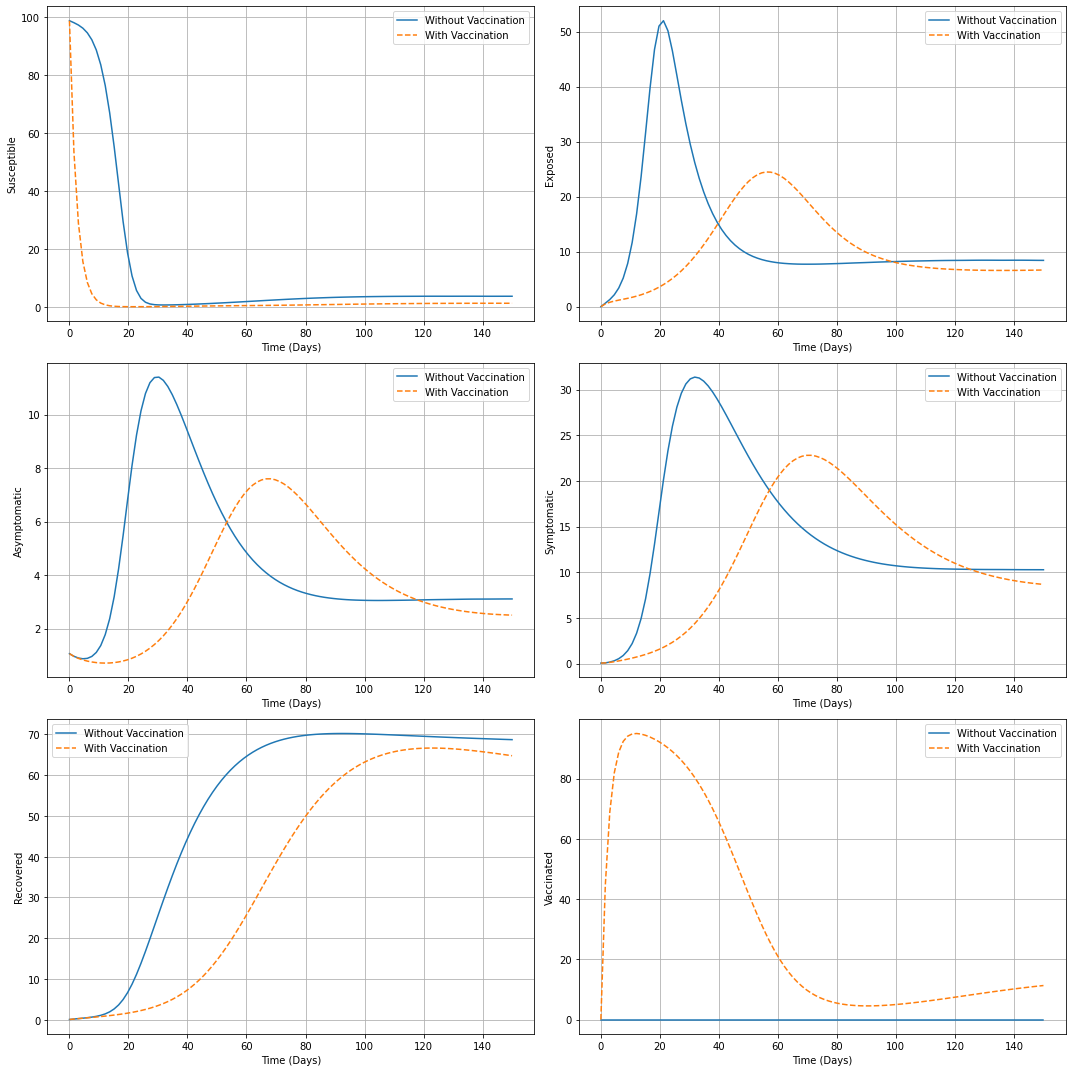

In [7]:
# Comparison between population with no vaccinations and with vaccinations

initial = [93000, 0, 1000, 50, 50, 0] # initial condition

plt.figure(figsize = (15, 15))
labels = ["Susceptible", "Exposed", "Asymptomatic", "Symptomatic", "Recovered", "Vaccinated"]

v = 0 # No Vaccination
parameters = [b, mu, psi, delta, omega, v, 
              sigma, gammaA, gammaI, nu]

#solve the DEs for population with vaccination
soln = solve_ivp(SEAIRV, (0, tmax), initial, t_eval = time, args = [parameters])

# plot each compartment separately
for i in range(len(labels)):
    plt.subplot(3, 2, i + 1)
    plt.plot(time, soln.y[i] / sum(initial) * 100, label = "Without Vaccination")
    plt.xlabel("Time (Days)")
    plt.ylabel(labels[i])
    plt.legend()
    

v = 0.4 # With Vaccination
parameters = [b, mu, psi, delta, omega, v, 
              sigma, gammaA, gammaI, nu]

#solve the DEs for population with vaccination
soln = solve_ivp(SEAIRV, (0, tmax), initial, t_eval = time, args = [parameters])

# plot each compartment separately
for i in range(len(labels)):
    plt.subplot(3, 2, i + 1)
    plt.plot(time, soln.y[i] / sum(initial) * 100, "--", label = "With Vaccination")
    plt.legend()
    plt.grid()
    
plt.tight_layout()

## Discussion and Conclusion

1. Interactions Model (SEAIRP Model)

In this model, alpha1 and alpha2 are reciprocal of the frequency with which individuals acquires COVID-19 from the environment and from infected individuals [3]. 

When both alpha1 and alpha2 = 0.05 (i.e high risk of getting infected by a contaminated environment and infected individuals), the virus swept through the population quickly. Around 60% of the population got exposed to the virus just after less than 10 days, while more than 40% are infected after 20 days (both asymptomatic and symptomatic). 

On the contrary, when both alpha1 and alpha2 = 0.5 (i.e low risk of getting infected by a contaminated environment and infected individuals), the virus spread slowly. Around 20% of the population is exposed after 20 days, and only around 20% of the population is infected after 40 days (both asymptomatic and symptomatic). 

The percentage of susceptible individuals, however, decreases slower in the low interactions model. As such, aside from social distancing and quarantine, we need a more effective and long-term measure.

2. Vaccination Model (SEAIRV Model)

In this model, the assumed vaccination rate is 0.4 [3]. This model doesn't consider exposed or infected individuals who are vaccinated, or how the effectiveness of the vaccines wears off over time. It does, however, consider the rate at which recovered individuals lose their immunity. 

With a vaccination rate of 0.4, nearly all of the population are vaccinated after 10 days, as such, the percentage of susceptible individuals decreases dramatically and reaches 0% after just 10 days, before slowly increasing as time goes on. The spread of the virus is also slowed down by the vaccines, in that around 30% of the population are infected after 70 days, compared to more than 40% after 30 days with no vaccination. Vaccination also decreases the risks of being exposed to the virus, in that around 25% of the population is exposed after 60 days, compared to more than 50% after just 20 days with no vaccination.

In conclusion, both measures accomplish what's called "flattening the curve", in which they both reduce and delay the peak of active cases, allowing more time for healthcare capacity to increase and better cope with patient load. Time gained through thus flattening the curve can be used to raise the line of healthcare capacity to better meet surging demand [4]. For this, they are both necessary and vital public health strategies to slow down the spread of the SARS-CoV-2 virus. 

If I were to investigate the effect of these two measures again, I would take into account whether some parts of the population are more susceptible to the virus than others, and I would like to make a model that can see the combined effect of both. I found one paper [5] that had successfully done this, they had even compared their models to real-world data and one of them matched pretty well. However, this paper's models didn't take into account the natural birth rate and death rate of a human population. I want to create an endemic model that achieves the same thing. 


### References

1. World Health Organization. (n.d.). Coronavirus. World Health Organization. Retrieved November 24, 2022, from https://www.who.int/health-topics/coronavirus#tab=tab_1 

2. Mwalili, S., Kimathi, M., Ojiambo, V., Gathungu, D., &amp; Mbogo, R. (2020). SEIR model for covid-19 dynamics incorporating the environment and social distancing. BMC Research Notes, 13(1). https://doi.org/10.1186/s13104-020-05192-1 

3. Diagne, M. L., Rwezaura, H., Tchoumi, S. Y., &amp; Tchuenche, J. M. (2021). A mathematical model of COVID-19 with vaccination and treatment. Computational and Mathematical Methods in Medicine, 2021, 1–16. https://doi.org/10.1155/2021/1250129 

4. Wikimedia Foundation. (2022, October 26). Flattening the curve. Wikipedia. Retrieved November 24, 2022, from https://en.wikipedia.org/wiki/Flattening_the_curve 

5. Dashtbali, M., &amp; Mirzaie, M. (2020). A compartmental model that predicts the effect of social distancing and vaccination on controlling COVID-19. https://doi.org/10.21203/rs.3.rs-104025/v1 